# Brain Tumor Segmentation (v1): **DeepLabV3** architecture with a pretrained `ResNet-50` encoder.

This notebook fine-tunes a pretrained DeepLabV3 (ResNet-50) model from torchvision for binary brain tumor segmentation on single-channel (grayscale) MRI slices.

Primary goals:

- Adapt a pretrained DeepLabV3 model to accept 1-channel input and output two classes (background vs tumor).
- Freeze the ResNet backbone and fine-tune the segmentation heads to leverage pretrained features while reducing training time.
- Create a robust PyTorch Dataset and DataLoaders for grayscale images and binary masks.
- Use Dice loss and MONAI's Dice metric for segmentation-specific optimization and evaluation. Automatic Mixed Precision (AMP) is enabled for faster GPU training.

Assumptions:

- Input images are stored as PNG files in `brain_tumor_dataset/images` and masks in `brain_tumor_dataset/masks`.
- Masks are binary or use 0/255; the dataset class binarizes masks automatically.


In [1]:
import torch
import torchvision


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__, torchvision.__version__

(device(type='cuda'), '2.8.0+cu126', '0.23.0+cu126')

## 1. Load the pretrained model

We load DeepLabV3 (ResNet-50) with torchvision's DEFAULT weights to leverage pretrained feature extractors. The weights object provides a `transforms()` helper describing the original model's expected preprocessing.

Because our MRI slices are grayscale, we build a custom transform pipeline that:

- Resizes images to the network's expected resolution,
- Converts RGB to a single grayscale channel,
- Converts to a tensor and normalizes with a 1-channel mean/std.

After loading the pretrained model we will:

1. Freeze the backbone parameters to keep pretrained features fixed during initial training.
2. Replace the classifier and auxiliary classifier to output 2 channels (background vs tumor).
3. Update the first convolution to accept a single input channel.

This approach reduces the amount of training required while adapting the architecture to our data.


In [ ]:
weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
transforms = weights.transforms()

deeplap_V3 = torchvision.models.segmentation.deeplabv3_resnet50(weights = weights)
deeplap_V3

In [ ]:
from torchinfo import summary

summary(
    deeplap_V3,
    # The input size should match the model's 2D configuration: (batch_size, channels, height, width)
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params", "trainable"),
)

In [4]:
transforms # notice how the mean and std are on 3 channels, but we need only one

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
# Define the transform for single-channel (grayscale) images
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

deeplab_V3_transform = T.Compose([
    T.ToPILImage(), # fixes a numpy type error
    T.Resize(520, interpolation=InterpolationMode.BILINEAR),
    T.Grayscale(num_output_channels=1),   # convert to 1 channel
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])    # adjust mean/std for 1 channel
])

In [ ]:
from torchinfo import summary

# Freeze backbone
for param in deeplap_V3.backbone.parameters():
    param.requires_grad = False

# ======================================================================== #
# FURTHER FREEZING (reducing trainable params from 18,489,412 to 4,164)
# a 4,440× reduction in the number of parameters being updated each step.
# ========================================================================= #
# Freeze classifier except final conv
for name, param in deeplap_V3.classifier.named_parameters():
    if not isinstance(param, torch.nn.Conv2d) or "4" not in name or "13" not in name:  # keep only final conv2d trainable
        param.requires_grad = False

# Freeze aux classifier except final conv
for name, param in deeplap_V3.aux_classifier.named_parameters():
    if not isinstance(param, torch.nn.Conv2d) or "4" not in name or "18" not in name: # keep only final conv2d trainable
        param.requires_grad = False
    
# Change classifier and auxiliary head to 2 only
deeplap_V3.classifier[4] =  torch.nn.Conv2d(256, 2, # this is the only change
                                            kernel_size=(1, 1), stride=(1, 1))
deeplap_V3.aux_classifier[4] =  torch.nn.Conv2d(256, 2, # this is the only change
                                                kernel_size=(1, 1), stride=(1, 1))

# Change the input to be 1 channel only (not 3)
deeplap_V3.backbone['conv1'] = torch.nn.Conv2d (1 # this is the only change
                                                , 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

summary(
    deeplap_V3,
    # The input size should match the model's 2D configuration: (batch_size, channels, height, width)
    input_size=(1, 1, 224, 224),
    col_names=("input_size", "output_size", "num_params", "trainable"),
)

## 2. Create dataset and dataloaders

This section prepares the dataset and DataLoaders. Steps:

1. Implement a custom Dataset that reads grayscale images and masks, binarizes masks, and applies optional transforms (e.g., resizing/augmentation).
2. Instantiate the full dataset and split it into training and validation subsets (80/20 split).
3. Create DataLoaders with appropriate batch sizes and worker counts for training and validation.

Keep the transforms consistent between training and validation (except for any augmentations you only want during training).


### 2.1 Dataset details

The custom `BrainTumorDataset` does the following:

- Loads images and masks from the provided directories and sorts filenames to keep pairs aligned.
- Converts both image and mask to grayscale (`L` mode) and returns them as NumPy arrays.
- Binarizes masks by thresholding at 127 (so 0/255 masks become 0/1).
- If a transform is provided (e.g., Albumentations), it is applied to both image and mask together.

Important: Ensure the dataset directories contain matching image/mask pairs and are named consistently.


In [7]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class BrainTumorDataset(Dataset):
    """Custom PyTorch Dataset for loading brain tumor images and masks."""
    
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        """
        Args:
            image_dir (pathlib.Path or str): Directory with all the images.
            mask_dir (pathlib.Path or str): Directory with all the masks.
            image_transform (callable, optional): Transform for images.
            mask_transform (callable, optional): Transform for masks.
    """
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        # Get all image and mask file paths and sort them to ensure they correspond
        self.images = sorted(list(image_dir.glob("*.png")))
        self.masks = sorted(list(mask_dir.glob("*.png")))
        
        # Ensure the number of images and masks are the same for data integrity
        assert len(self.images) == len(self.masks), "Number of images and masks must be equal."

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index, loads it, and applies transforms.

        Args:
            idx (int): The index of the sample to fetch.

        Returns:
            tuple: (image, mask) where image is the transformed image and mask is the transformed mask.
        """
        # Get the file paths for the image and mask
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        
        # Open the image and mask files
        # Images and masks are converted to grayscale (L) for single-channel processing
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        
        # Normalize mask to be 0 or 1, as pixel values are often 0 and 255
        # A more robust and explicit way to binarize the mask
        mask = (mask > 127).astype(np.float32)
        
        """
        (mask > 127): This creates a boolean array 
                    where pixels with a value greater than 127 become True 
                    and all others become False.
                    
        .astype(np.float32): This converts the boolean array into a float array, 
                            where True becomes 1.0 and False becomes 0.0.
        """

        
        # Apply transformations if they are provided
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask



In [8]:
# Define the transform for single-channel (grayscale) images
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Define separate, robust transformation pipelines for images and masks.
# This is critical because masks require different handling (e.g., no normalization).

# Transform for the IMAGES
image_transform = T.Compose([
    T.ToPILImage(), # fixes a numpy type error
    T.Resize((520, 520), interpolation=InterpolationMode.BILINEAR),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # Normalization is for images only
])

# Transform for the MASKS
mask_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520), interpolation=InterpolationMode.NEAREST), # Use NEAREST to preserve 0/1 values,
    T.Grayscale(num_output_channels=1),
    T.ToTensor()  # DO NOT normalize masks
])

In [9]:
# init datasets
from pathlib import Path
from torch.utils.data import random_split


IMAGES_DIR = Path("brain_tumor_dataset/images")
MASKS_DIR = Path("brain_tumor_dataset/masks")

# 1. Instantiate the full dataset
full_dataset = BrainTumorDataset(image_dir= IMAGES_DIR,
                            mask_dir= MASKS_DIR,
                            image_transform = image_transform,
                            mask_transform= mask_transform)

# 2. Define split sizes (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# 3. Perform the split
generator = torch.Generator().manual_seed(42) # for reproducibility
train_dataset, val_dataset = random_split(full_dataset, 
                                        [train_size, val_size], 
                                        generator=generator)

# Test print lengths
print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")

print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train dataset: <torch.utils.data.dataset.Subset object at 0x0000020278806740>
Validation dataset: <torch.utils.data.dataset.Subset object at 0x0000020278807C70>
Total samples: 3064
Training samples: 2451
Validation samples: 613


### 2.2 DataLoaders

We create PyTorch DataLoaders for training and validation. Important considerations:

- Use `shuffle=True` for the training loader to randomize samples each epoch.
- Use reasonable `batch_size` values based on GPU memory.
- Set `num_workers` to a value appropriate for your machine (e.g., `os.cpu_count()`), and use `pin_memory=True` when training on CUDA.

The loaders return (image, mask) tuples ready for the training loop.


In [10]:
import os
os.cpu_count()

16

In [11]:
from torch.utils.data import DataLoader


# --- Hyperparameters for Data Loading ---
# BATCH_SIZE: Increase this to the largest value that fits on your GPU VRAM.
BATCH_SIZE = 8

# NUM_WORKERS: The number of parallel processes for data loading.
# On Windows, setting this > 0 can cause a deadlock if not handled carefully.
# Start with 0 to ensure the program runs. If it works, you can try a small
# number like 2 or 4. Using os.cpu_count() is often unstable on Windows.
NUM_WORKERS = os.cpu_count() # START WITH 0 TO FIX THE HANG.

train_loader = DataLoader(dataset= train_dataset,
                        shuffle= True,
                        
                        batch_size= BATCH_SIZE,
                        num_workers= 0,
                        
                        pin_memory= True)

val_loader = DataLoader(dataset= val_dataset,
                        shuffle= False,
                        
                        batch_size= BATCH_SIZE,
                        num_workers= 0,

                        pin_memory= True)
                        

train_loader, val_loader



(<torch.utils.data.dataloader.DataLoader at 0x202788040a0>,
 <torch.utils.data.dataloader.DataLoader at 0x20278804dc0>)

## 3. Loss function, optimizer, and metrics

Choices and rationale:

- Loss: MONAI's `DiceLoss(sigmoid=True)` is used because Dice is appropriate for segmentation and encourages overlap between predictions and ground truth. `sigmoid=True` applies a per-pixel sigmoid to raw logits.
- Optimizer: Adam with a small learning rate (1e-4) is a good default for fine-tuning segmentation heads.
- Scheduler: `ReduceLROnPlateau` reduces the learning rate if validation loss plateaus, helping escape local minima.
- Metric: MONAI's `DiceMetric` (with `include_background=False`) evaluates segmentation quality excluding background to focus on tumor detection.
- AMP: Automatic Mixed Precision via `torch.amp.GradScaler` speeds up training on modern GPUs and reduces memory usage.

We also keep a `best_val_dice` to checkpoint the best-performing model during training.


In [12]:
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

# Move the model to the target device (GPU/CPU) before creating the optimizer.
# This ensures that the optimizer is initialized with the model parameters on the correct device.
deeplap_V3.to(device)

# Define the loss function. DiceCELoss combines Dice and Cross-Entropy for more stable training.
# For multi-class output (even with 2 classes), softmax is the correct activation.
# to_onehot_y=True converts the single-channel mask to a 2-channel one-hot mask.
# It applies a sigmoid to the output before calculating loss.
class_weights = torch.tensor([0.1, 0.9], device=device)  # background, foreground
loss_fn = DiceCELoss(softmax=True,
                    to_onehot_y=True,
                    include_background=True,
                    weight=class_weights )

# Define the optimizer.
optimizer = torch.optim.Adam(deeplap_V3.parameters(), 
                            lr=1e-4)

# Define a learning rate scheduler. 
# It will reduce the learning rate when the validation loss stops improving ('min' mode).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min', 
                                                        factor=0.1, 
                                                        patience=10)


# Initialize the Dice Metric for evaluating segmentation performance.
# `include_background=False` means the background class (label 0) is ignored during calculation.
# `reduction="mean"` specifies that the Dice scores for all classes will be averaged.
metric = DiceMetric(include_background=False,
                    reduction= "mean")

# Set the total number of training epochs.
epochs = 10

# Initialize a variable to track the best validation Dice score achieved so far.
# This is used to save the best performing model checkpoint.
best_val_dice = 0.0

# Initialize a Gradient Scaler for Automatic Mixed Precision (AMP) training.
# This helps prevent underflow of gradients when using float16 precision,
# improving training stability and speed on compatible GPUs.
scaler = torch.amp.GradScaler(device = "cuda")



## 4. Training loop

Training uses a modular engine (imported from `going_modular.engine`) to encapsulate the training and validation steps. Key points:

- The engine handles forward/backward passes, loss computation, metric updates, AMP scaling, scheduler steps, and checkpointing.
- Provide model, data loaders, loss function, optimizer, scheduler, scaler, device, number of epochs, and a checkpoint directory.
- Checkpointing saves the best model (by validation Dice) so you can resume or evaluate the best weights later.

After training, inspect the saved checkpoints and validation metrics to assess performance. Consider unfreezing parts of the backbone and fine-tuning with a lower learning rate if more improvement is needed.


In [13]:
# # TESTING

# from going_modular import engine

# mean_dice, mean_accuracy = engine.evaluate(model = deeplap_V3, 
#                                             loader = val_loader,
#                                             metric = metric,
#                                             device = device,
#                                             epoch_num = 1)

# mean_dice, mean_accuracy

In [ ]:
from engine import train, plot_results

results = train(model = deeplap_V3,
                    
                    train_loader = train_loader,
                    test_loader = val_loader, 
                    
                    loss_fn = loss_fn, 
                    metric = metric,
                    optimizer = optimizer, 
                    scheduler = scheduler,
                    scaler = scaler, 
                    
                    device = device, 
                    epochs = epochs,
                    checkpoint_dir = "checkpoints_2/ ")


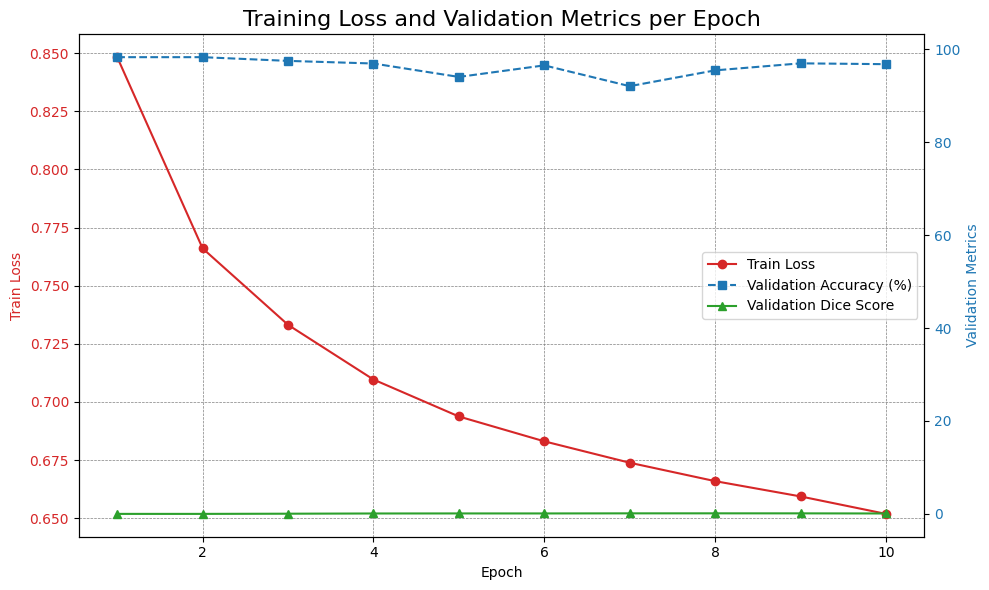

In [ ]:
plot_results(results)